# Explore GRS images

## Load python libraries

In [1]:

import glob
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray  # activate the rio accessor

#import cartopy
import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import locale
#locale.setlocale(locale.LC_ALL, 'en_US.utf8')
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.use('TkAgg')
import hvplot.xarray

import holoviews as hv
import holoviews.operation.datashader as hd
from holoviews import opts
hv.extension('bokeh')
import datashader as ds
from datashader import transfer_functions as tf 
import colorcet as cc
import panel as pn
import panel.widgets as pnw
#import ipywidgets as widgets

import pyproj as ppj
import rasterio
from affine import Affine
from shapely.geometry import box,Point, mapping
from shapely.ops import transform


import grstbx
from grstbx import visual

u = grstbx.utils
opj = os.path.join
grstbx.__version__

'2.0.0'

## Set Dask local cluster

In [2]:
import dask.distributed
cluster = dask.distributed.LocalCluster()
client = dask.distributed.Client(cluster)
cluster.dashboard_link

'http://127.0.0.1:8787/status'

## Set images to play with

In [3]:
data_dir = '/data/satellite/S2/cnes/validation'
aeronet_site = 'Bahia_Blanca'
select =grstbx.select_files()
# if you need to change the root path
select.root= opj(data_dir,aeronet_site)
pattern='*'+aeronet_site+'*.nc'
select.select_pattern(pattern)
select.file_list



,satellite,level,tile,cloud_coverage,version,abspath
date,,,,,,
2020-01-27 13:56:39,S2B,MSIL1C,T20HPB,16.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2020-01-29 13:46:41,S2A,MSIL1C,T20HPB,50.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2020-02-01 13:56:41,S2A,MSIL1C,T20HPB,0.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2020-02-03 13:46:39,S2B,MSIL1C,T20HPB,6.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2020-02-06 13:56:39,S2B,MSIL1C,T20HPB,67.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
...,...,...,...,...,...,...
2021-11-02 14:01:01,S2A,MSIL1C,T20HPB,0.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2021-11-04 13:51:19,S2B,MSIL1C,T20HPB,100.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2021-11-07 14:00:49,S2B,MSIL1C,T20HPB,95.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...


### Select date range and maximum cloud cover (cc_max)

In [4]:
files = select.list_file_path(('2020-01','2022-02-15'),cc_max=80)
select.file_list

,satellite,level,tile,cloud_coverage,version,abspath
date,,,,,,
2020-01-27 13:56:39,S2B,MSIL1C,T20HPB,16.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2020-01-29 13:46:41,S2A,MSIL1C,T20HPB,50.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2020-02-01 13:56:41,S2A,MSIL1C,T20HPB,0.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2020-02-03 13:46:39,S2B,MSIL1C,T20HPB,6.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2020-02-06 13:56:39,S2B,MSIL1C,T20HPB,67.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
...,...,...,...,...,...,...
2021-10-10 13:51:21,S2A,MSIL1C,T20HPB,0.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2021-10-13 14:01:01,S2A,MSIL1C,T20HPB,76.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...
2021-10-15 13:51:19,S2B,MSIL1C,T20HPB,0.0,v15,/data/satellite/S2/cnes/validation/Bahia_Blanc...


## Load and subset image series

In [6]:

# generate datacube
dc = grstbx.l2grs_v1(files)

In [7]:
dc.load(reshape=True)

## Check data/metadata

In [8]:
dc.raster

<xarray.Dataset>
Dimensions:      (x: 364, y: 364, time: 131, wl: 9)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 6.068e+05 6.068e+05 ... 6.14e+05 6.141e+05
  * y            (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.662e+06 5.662e+06
  * time         (time) datetime64[ns] 2020-01-27T13:56:39.023999 ... 2021-11...
  * wl           (wl) float32 442.3 492.1 558.9 664.9 ... 779.7 832.9 864.0
Data variables:
    Rrs          (wl, time, y, x) float32 dask.array<chunksize=(1, 1, 364, 364), meta=np.ndarray>
    SZA          (time, y, x) float32 dask.array<chunksize=(1, 364, 364), meta=np.ndarray>
    AZI          (time, y, x) float32 dask.array<chunksize=(1, 364, 364), meta=np.ndarray>
    VZA          (time, y, x) float32 dask.array<chunksize=(1, 364, 364), meta=np.ndarray>
    shade        (time, y, x) float32 dask.array<chunksize=(1, 364, 364), meta=np.ndarray>
    BRDFg        (time, y, x) float32 dask.array<chunksize=(1, 364, 364), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.4
    TileSize:          364:364
    product_type:      L2grs
    metadata_profile:  beam
    metadata_version:  0.5
    auto_grouping:     Rrs:Rrs_g_
    start_date:        2020-01-27T13:56:39.023999000
    stop_date:         2021-11-14T13:51:09.024000000

## Check flags and masking

In [9]:
pn.widgets.DataFrame(pd.DataFrame.from_dict(dc.datacube.metadata.attrs,orient='index'),height=300)


DataFrame(height=300, value=              ...)

## Check flags and masking

In [12]:
masking_ = grstbx.masking(dc.datacube.isel(time=0))
masking_.print_info()

,description,value,bit
name,,,
nodata,nodata in input image,1,0
negative,negative values in visible,2,1
ndwi,based on ndwi vis nir TOA based on bands B3 an...,4,2
ndwi_swir,based on ndwi nir swir TOA based on bandsB8A a...,8,3
high_nir,"high radiance in the nir band (e.g., cloud, sn...",16,4
hicld,high cloud as observed from cirrus band; condi...,32,5
moderate_cloud_risk_O2band,moderate risk of bright cloud as observed from...,64,6
high_cloud_risk_O2band,high risk of bright cloud as observed from O2 ...,128,7
L1_opaque_clouds,flag from L1 image,256,8


In [22]:
mask,value = masking_.compute_mask_value(high_nir=True,ndwi=False)
print(mask,value) #(dc.datacube.isel(time=6).flags & 10 == 16).plot()

20 16


In [27]:
dc.datacube.isel(time=6).flags# & 32).plot()

<xarray.DataArray 'flags' (y: 364, x: 364)>
dask.array<getitem, shape=(364, 364), dtype=uint32, chunksize=(364, 364), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 6.068e+05 6.068e+05 ... 6.14e+05 6.141e+05
  * y            (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.662e+06 5.662e+06
    time         datetime64[ns] 2020-02-13T13:46:39.024000
Attributes:
    long_name:          Flags for aquatic color purposes
    flag_meanings:      nodata negative ndwi ndwi_swir high_nir hicld moderat...
    flag_masks:         [       1        2        4        8       16       3...
    flag_coding_name:   flags
    flag_descriptions:  nodata in input image \tnegative values in visible \t...

In [29]:
value

16

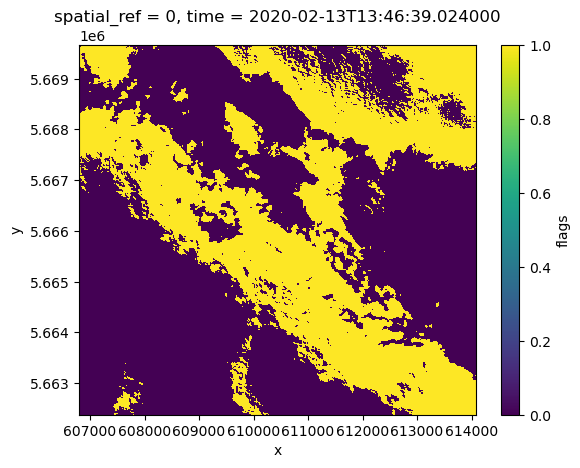

In [23]:
(dc.datacube.isel(time=6).flags & mask == value).plot()

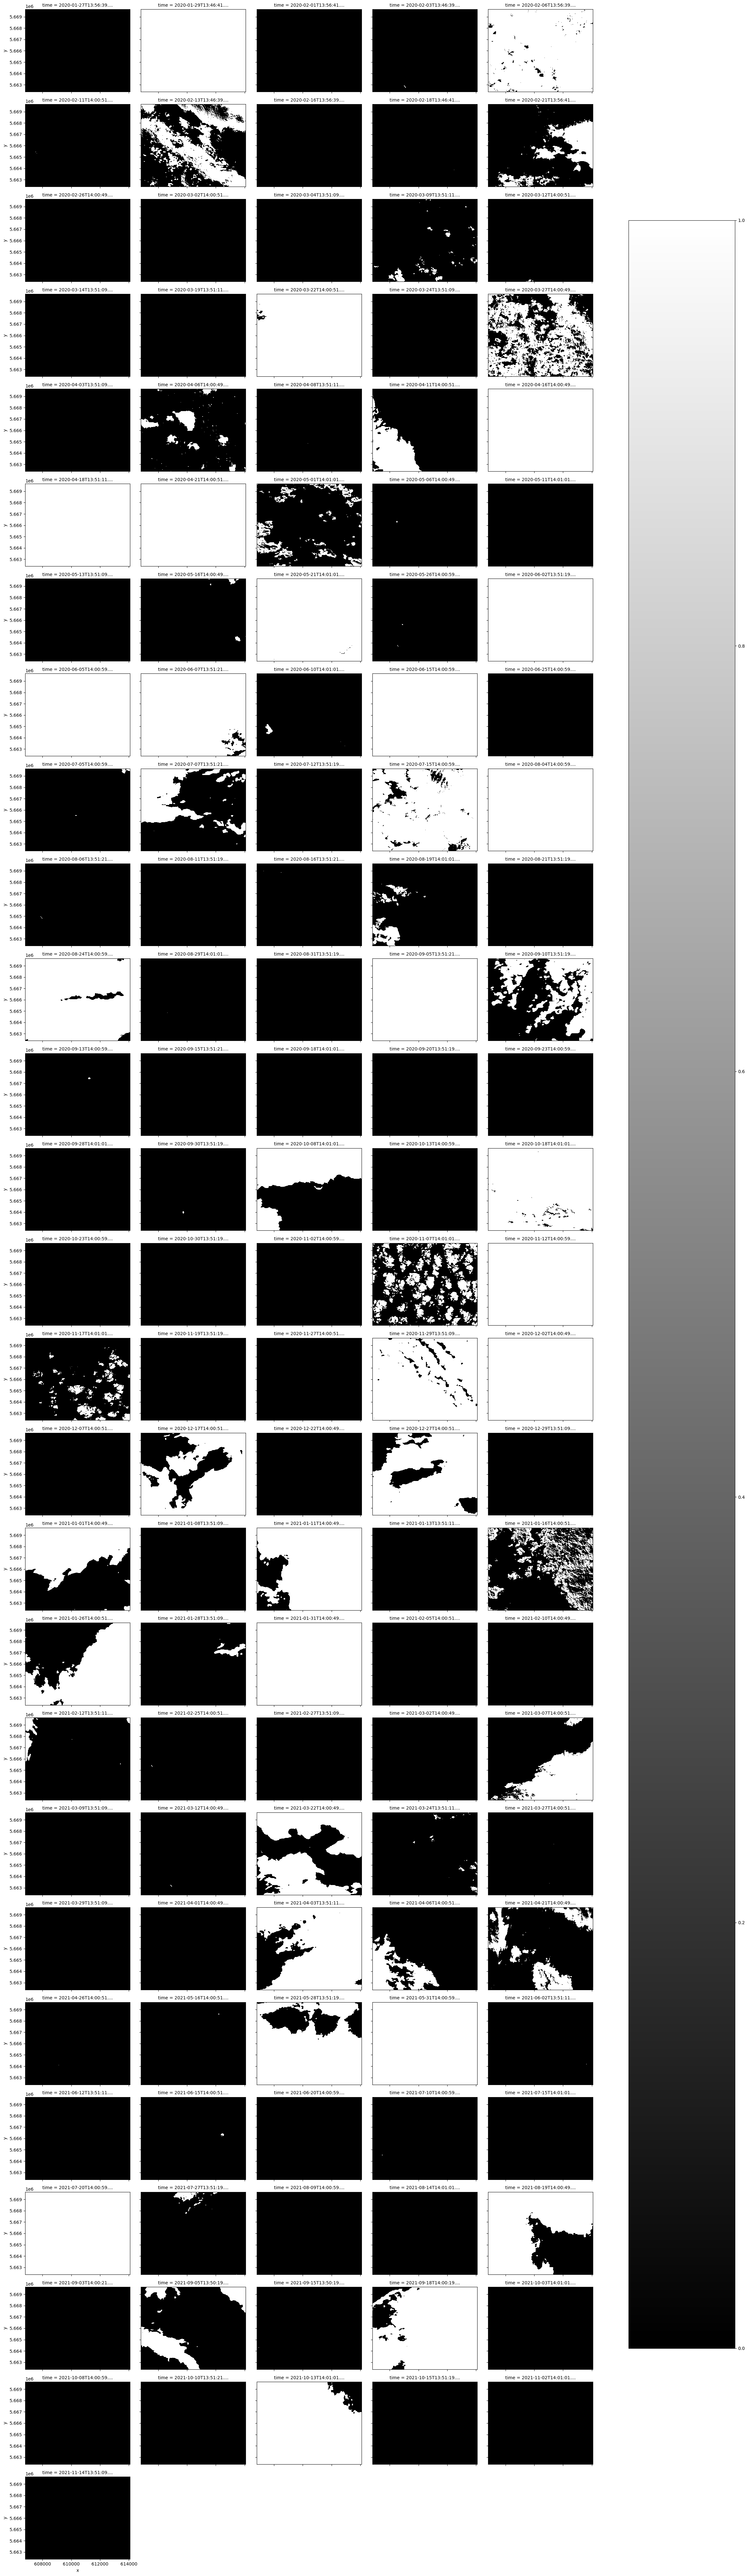

In [11]:
mask = (masking_.get_mask(high_nir=True) | masking_.get_mask(hicld=True)) | (dc.raster.Rrs.isel(wl=2) < 0.0002)
aspect=1.5
mask.plot.imshow(col='time',col_wrap=5,vmin=0,cmap=plt.cm.binary_r,aspect=aspect)

## Mask datacube
Mask pixels from chosen flags and remove empty dates

In [11]:
Rrs_masked = dc.raster.Rrs.where(mask==0).dropna('time','all')
BRDFg = dc.datacube.BRDFg.where(mask==0).dropna('time','all')
BRDFg = BRDFg.where(masking_.get_mask(ndwi=False),drop=True)

In [12]:
# Rrs_masked= Rrs_masked.as_numpy()

## Visualize and clip the raster image for the selected area of interest (last polygon drawn)

In [13]:
v=visual.view_spectral(Rrs_masked)

In [14]:
v.visu()

Column
    [0] WidgetBox
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Row
                    [0] Markdown(str)
                    [1] RadioButtonGroup(options=[0, 1, 2, 3, 4, ...], value=2)
                [1] Row
                    [0] Markdown(str)
                    [1] DatePicker(enabled_dates=[datetime.date(2020, ...], start=datetime.date(2020, ..., value=datetime.date(2020, ...)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(options=['CartoDark', ...], value='StamenTonerBackground')
            [1] Row
                [0] Row
                    [0] Markdown(str)
                    [1] RangeSlider(end=0.06, name='Range Slider', step=0.0001, value=(0, 0.02), value_end=0.02)
                [1] Row
                    [0] Markdown(str)
                    [1] FloatSlider(name='Opacity', step=0.05, value=0.95)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(options=['CET_D13', 'bky', ...], value='CET_D13')
    [1] HoloViews(DynamicMap)

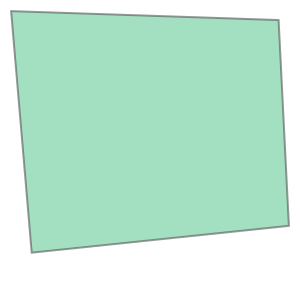

In [15]:
v.aoi_stream.element.geom()

### Clip raster and compute statistics 

In [16]:
from shapely.geometry import Polygon
geom = v.aoi_stream.data
ys,xs=geom['ys'][-1],geom['xs'][-1]
polygon_geom = Polygon(zip(xs, ys))
polygon = gpd.GeoDataFrame(index=[0], crs=3857, geometry=[polygon_geom]) 
geom_ = polygon.to_crs(3857)#Rrs_masked.rio.crs) #4326)#32631)#4326)
geom_.to_crs(4326).bounds

# if you want to subset within the box (defined from the polygon) uncomment the following lines
#minx, miny, maxx, maxy = geom_.bounds.values[0]

#Rrs_masked.sel(x=slice(minx, maxx), y=slice(maxy, miny))
geom_=geom_.to_crs(Rrs_masked.rio.crs)


In [17]:
Rrs_clipped = Rrs_masked.rio.clip(geom_.geometry.values)

NoDataInBounds: No data found in bounds. Data variable: Rrs

In [18]:
stacked = Rrs_clipped.stack(gridcell=["y", "x"])#.dropna('gridcell',thresh=0)


NameError: name 'Rrs_clipped' is not defined

In [ ]:
group_coord ='wl'
stat_coord='gridcell'
stats = xr.Dataset({'median':stacked.groupby(group_coord).median(stat_coord)})
stats['q25'] = stacked.groupby(group_coord).quantile(0.25,dim=stat_coord)
stats['q75'] = stacked.groupby(group_coord).quantile(0.75,dim=stat_coord)
stats['min'] = stacked.groupby(group_coord).min(stat_coord)
stats['max'] = stacked.groupby(group_coord).max(stat_coord)
stats['mean'] = stacked.groupby(group_coord).mean(stat_coord)
stats['std'] = stacked.groupby(group_coord).std(stat_coord)
stats['pix_num'] = stacked.count(stat_coord)

### Based on statistics drop out bad dates (example: a least 50% of the selected pixels must be valid)

In [ ]:
pix_num_max = stats.pix_num.values.max()
valid_thresh = 0.5
date_to_remove = stats.time.values[stats.pix_num.isel(wl=1)<valid_thresh*pix_num_max]
date_to_remove
#stats.pix_num<valid_thresh*pix_num_max

In [ ]:
Rrs_clipped = Rrs_clipped.drop_sel(time=date_to_remove)
stats = stats.drop_sel(time=date_to_remove)

### Check and analyze the time series

In [ ]:
fig = Rrs_clipped.isel(wl=2).plot.imshow(col='time',col_wrap=10,vmin=0,cmap=cc.cm.bky,robust=True)
for ax in fig.axs.flat:
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel('')
    ax.set_xlabel('')
fig

In [ ]:
%matplotlib inline
num_items = len(stats.time)
col_wrap=5
rows=int(np.ceil(num_items/col_wrap))

fig, axs = plt.subplots(nrows=rows,ncols=col_wrap, sharex=True,figsize=(20, rows*3.5),sharey=True)
fig.subplots_adjust(hspace=0.1,wspace=0.1)
axs_ = axs.ravel()
[axi.set_axis_off() for axi in axs_]
for iax,(_,group) in enumerate(stats.groupby('time')): 
    date = group.time.dt.date.values
    
    axs_[iax].set_axis_on()
    axs_[iax].axhline(y=0,color='k',lw=1)
    axs_[iax].plot(group.wl,group['median'],c='k')
    axs_[iax].plot(group.wl,group['mean'],c='red',ls='--')
    axs_[iax].fill_between(group.wl, group['q25'], group['q75'],alpha=0.3,color='grey')
    axs_[iax].set_title(date)
plt.show()

In [ ]:
t = hv.Table(stats,['time','wl'])
val='pix_num'
c=t.to.curve('time',val)
s=t.to.scatter('time',[val,'std'])
(c*s).opts(
    opts.Curve(color='k',width=1), 
    opts.Scatter(cmap='Blues', color='std', alpha=0.5,
                 line_color='k', size=hv.dim('std')*1000),
    opts.Text(text_font_size='13px'),
    opts.Overlay(height=400, show_frame=False, width=1000)).opts(fontscale=1.4,padding=0.1)


In [ ]:
ds = hv.Dataset(stats)
c = ds.to(hv.Curve, 'time','median','wl').overlay().opts(width=1200, height=400, legend_position='right')
#env = ds.to(hv.Area, 'time','q25','q75').overlay()
c#*env

In [ ]:
df = stats.to_dataframe().reset_index()
pn.widgets.DataFrame(df,height=300,width=1000)

In [ ]:
plt.figure()
for name,group in stacked.isel(time=60).groupby('gridcell'):
    g_=group
    plt.plot(g_.wl,g_.values,c='k',alpha=0.1,lw=1)#plot(x='wl')
plt.show()

## **Check spectral datacube** (i.e., Remote Sensing Reflectance, R<sub>rs</sub>, sr<sup>-1</sup>)

To quickly check your data visually, you can use the *visual* module of *grstbx*

In [ ]:
visual.image_viewer().Rrs_date(Rrs_masked)

## **Fast checking of the RGB images**

In [ ]:
bands=[4,2,1]
bands=[3,2,1]
fig = Rrs_clipped.isel(wl=bands).plot.imshow(col='time', col_wrap=8,robust=True)
for ax in fig.axs.flat:
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel('')
    ax.set_xlabel('')
fig


In [ ]:
import datashader as ds
from datashader import transfer_functions as tf 
from colorcet import palette


shaded = []
for name, raster in Rrs_masked.isel(wl=2).groupby('time'):
    img = tf.shade(raster.squeeze(),cmap=cc.kbc)
    img.name = str(name)
    shaded.append(img)

imgs = tf.Images(*shaded)
imgs.num_cols = 3
imgs

In [ ]:
from holoviews import opts

opts.defaults(
    opts.GridSpace(shared_xaxis=True, shared_yaxis=True),
    opts.Image(cmap='binary_r', width=800, height=700),
    opts.Labels(text_color='white', text_font_size='8pt', text_align='left', text_baseline='bottom'),
    opts.Path(color='white'),
    opts.Spread(width=900),
    opts.Overlay(show_legend=True))
# set the parameter for spectra extraction
hv.extension('bokeh')
pn.extension()

raster = Rrs_masked#.isel(time=-1,drop=True)
ds = hv.Dataset(raster.persist())
im= ds.to(hv.Image, ['x', 'y'], dynamic=True).opts(cmap= 'RdBu_r',colorbar=True)#.hist(bin_range=(0,0.02) ) 
widget = pn.widgets.RangeSlider(start=0, end=0.1,step=0.001)

jscode = """
    color_mapper.low = cb_obj.value[0];
    color_mapper.high = cb_obj.value[1];
"""
link = widget.jslink(im, code={'value': jscode})
pn.Column(widget, im)

# Check surface rugosity via sunglint BRDF

In [ ]:

raster = BRDFg#.isel(time=-1,drop=True)
ds = hv.Dataset(raster.persist())
im= ds.to(hv.Image, ['x', 'y'], dynamic=True).opts(cmap= 'gray',colorbar=True)#.hist(bin_range=(0,0.02) ) 
widget = pn.widgets.RangeSlider(start=0, end=0.01,step=0.0005)

jscode = """
    color_mapper.low = cb_obj.value[0];
    color_mapper.high = cb_obj.value[1];
"""
link = widget.jslink(im, code={'value': jscode})
pn.Column(widget, im)

In [ ]:

shaded = []
for name, raster in BRDFg.groupby('time'):
    img = tf.shade(raster.squeeze(),cmap=cc.gray)
    img.name = str(name)
    shaded.append(img)

imgs = tf.Images(*shaded)
imgs.num_cols = 5
imgs

## Check blue over green ratio for Chl retrieval with OC2 from NASA
$log_{10}(chlor\_a) = a_0 + \sum\limits_{i=1}^4 a_i \left(log_{10}\left(\frac{R_{rs}(\lambda_{blue})}{R_{rs}(\lambda_{green})}\right)\right)^i$

In [ ]:
# NASA OC2 fro MODIS; bands 488, 547 nm
a = [0.2500,-2.4752,1.4061,-2.8233,0.5405]
# NASA OC2 for OCTS; bands 490, 565 nm
a = [0.2236,-1.8296,1.9094,-2.9481,-0.1718]

ratio = np.log10(Rrs_masked.isel(wl=1)/Rrs_masked.isel(wl=2))
logchl=0
for i in range(len(a)):
    logchl+=a[i]*ratio**i
chl = 10**(logchl)
chl.name='chl in mg.m-3 from OC2'

Set range of valid values

In [ ]:
chl = chl.where((chl >= 0) & (chl <= 80))
chl.persist()



In [ ]:
visual.image_viewer().param_date(chl,cmap='bgyw')

In [ ]:
raster = chl

shaded = []
for name, raster in chl.groupby('time'):
    img = tf.shade(raster.squeeze(),cmap=cc.bgyw, span=(0,10),how='log')
    img.name = str(name)
    shaded.append(img)

imgs = tf.Images(*shaded)
imgs.num_cols = 4
imgs

# CDOM retrieval based on Brezonik et al, 2015


In [ ]:
a = [1.872,-0.83]
acdom = np.exp(a[0] + a[1] * np.log(Rrs_masked.isel(wl=1)/Rrs_masked.isel(wl=5)))
acdom.name='CDOM absorption at 440 nm-1'
acdom= acdom.where((acdom >= 0) & (acdom <= 10))
acdom.persist()

In [ ]:
visual.image_viewer().param_date(acdom,cmap='bgyw')

# Total suspended particulate matter (SPM) from Nechad et al., 2010, 2016 formulation
spm in mg/L

In [ ]:
a = [610.94*np.pi, 0.2324/np.pi]
Rrs_ = Rrs_masked.isel(wl=3)
spm = a[0] * Rrs_ / (1 - ( Rrs_/ a[1]))
spm.name='CDOM absorption at 440 nm-1'
spm= spm.where((spm >= 0) & (spm <= 150))
spm.persist()

In [ ]:
visual.image_viewer().param_date(spm,cmap='bgyw')

In [ ]:

shaded = []
for name, raster in dc.Rrs.Rrs.isel(time=-1).groupby('wl'):
    img = tf.shade(raster,cmap=cc.kbc)
    img.name = '{:.2f}'.format(name)+' nm'
    shaded.append(img)

imgs = tf.Images(*shaded)
imgs.num_cols = 3
imgs

In [ ]:
shaded = []
for name, raster in BRDFg.groupby('time'):
    img = tf.shade(raster,cmap=cc.gray, span=(0,0.025),how='log')
    img.name = str(name)
    shaded.append(img)

imgs = tf.Images(*shaded)
imgs.num_cols = 4
imgs

# Play with time series

In [ ]:
raster = spm

param = raster.name
third_dim = 'time'
time= raster.time.data
Ntime = len(time)
ds = hv.Dataset(raster.persist())
im= ds.to(hv.Image, ['x', 'y'], dynamic=True).opts(cmap= 'RdBu_r',colorbar=True,clim=(0,10))#.hist(bin_range=(0,0.02) ) 

polys = hv.Polygons([])
box_stream = hv.streams.BoxEdit(source=polys)
dmap, dmap_std=[],[]

def roi_curves(data,ds=ds):    
    if not data or not any(len(d) for d in data.values()):
        return hv.NdOverlay({0: hv.Curve([],'time', param)})

    curves,envelope = {},{}
    data = zip(data['x0'], data['x1'], data['y0'], data['y1'])
    for i, (x0, x1, y0, y1) in enumerate(data):
        selection = ds.select(x=(x0, x1), y=(y0, y1))
        mean = selection.aggregate(third_dim, np.nanmean).data
        print(mean)
        #std = selection.aggregate(third_dim, np.std).data
        time = mean[third_dim]

        curves[i]= hv.Curve((time,mean[param]),'time', param) 

    return hv.NdOverlay(curves)


# a bit dirty to have two similar function, but holoviews does not like mixing Curve and Spread for the same stream
def roi_spreads(data,ds=ds):    
    if not data or not any(len(d) for d in data.values()):
        return hv.NdOverlay({0: hv.Curve([],'time', param)})

    curves,envelope = {},{}
    data = zip(data['x0'], data['x1'], data['y0'], data['y1'])
    for i, (x0, x1, y0, y1) in enumerate(data):
        selection = ds.select(x=(x0, x1), y=(y0, y1))
        mean = selection.aggregate(third_dim, np.nanmean).data
        std = selection.aggregate(third_dim, np.nanstd).data
        time = mean[third_dim]

        curves[i]=  hv.Spread((time,mean[param],std[param]),fill_alpha=0.3)

    return hv.NdOverlay(curves)

mean=hv.DynamicMap(roi_curves,streams=[box_stream])
std =hv.DynamicMap(roi_spreads, streams=[box_stream])    


In [ ]:
# visualize and play
graphs = ((mean*std ).relabel(param))
layout = (im * polys +graphs    ).opts(
    opts.Curve(width=600, framewise=True), 
    opts.Polygons(fill_alpha=0.2, color='green',line_color='black'), 
    ).cols(2)
layout 

In [ ]:
selection = ds.select(x=(547000,547200), y=(4802000, 4803000))
mean = selection.aggregate(third_dim, np.nanmean).data
std = selection.aggregate(third_dim, np.std).data
time = mean[third_dim]
curves={}
for i in [0,1,2]:
    curves[i]=hv.Curve((time,mean[param]),'time', param)

hv.DynamicMap(hv.NdOverlay(curves)).opts(width=600)

In [ ]:
import bokeh
from holoviews import streams
import geoviews as gv
from cartopy import crs


    def __init__(self, raster, dates=None,
                 bands=None,
                 reproject=False,
                 minmax=(0, 0.02)):

        # layout settings
        self.width, self.height = 1200, 700
        self.key_dimensions = ['x', 'y']
        self.minmax = minmax

        # variables settings
        self.dates = dates
        if dates == None:
            self.dates = raster.time.dt.date.values
        self.bands = bands
        if bands == None:
            self.bands = raster.wl.values

        # load raster
        self.raster = raster
        self.dataarrays = {}
        self.aoi_polygons  = gv.Polygons([], crs=crs.epsg(3857))#.opts(opts.Polygons(fill_alpha=0.3,fill_color='white',line_width=1.5))#, active_tools=['poly_draw']))#.opts(crs.GOOGLE_MERCATOR)
       
        self.aoi_stream  = hv.streams.PolyDraw(source=self.aoi_polygons)#, drag=True)#, num_objects=1)#5,styles={'fill_color': aoi_colours})
        self.edit_stream  = hv.streams.PolyEdit(source=self.aoi_polygons)#, drag=True)
        
        for itime, time in enumerate(raster.time.values):
            raster_ = raster.sel(time=time)
            for iband, band in enumerate(self.bands):
                if reproject:
                    self.dataarrays[itime, iband] = raster_.sel(wl=band).rio.reproject(3857, nodata=np.nan)
                else:
                    self.dataarrays[itime, iband] = raster_.sel(wl=band)
            

    @staticmethod
    def custom_hover():
        formatter_code = """
          var digits = 4;
          var projections = Bokeh.require("core/util/projections");
          var x = special_vars.x; var y = special_vars.y;
          var coords = projections.wgs84_mercator.invert(x, y);
          return "" + (Math.round(coords[%d] * 10**digits) / 10**digits).toFixed(digits)+ "";
        """
        formatter_code_x, formatter_code_y = formatter_code % 0, formatter_code % 1
        custom_tooltips = [('Lon', '@x{custom}'), ('Lat', '@y{custom}'), ('Value', '@image{0.0000}')]
        custom_formatters = {
            '@x': bokeh.models.CustomJSHover(code=formatter_code_x),
            '@y': bokeh.models.CustomJSHover(code=formatter_code_y)
        }
        return bokeh.models.HoverTool(tooltips=custom_tooltips, formatters=custom_formatters)
    
    def print_geom(self):
            return self.aoi_stream

    def visu(self):
        dates = self.dates
        bands = self.bands
        hv.opts.defaults(
            hv.opts.Image(height=self.height, width=self.width,
                          colorbar=True, tools=[self.custom_hover()], active_tools=['wheel_zoom'],
                          clipping_colors={'NaN': '#00000000'}),
            hv.opts.Tiles(active_tools=['wheel_zoom'])
        )
        gopts = hv.opts.Tiles(xaxis=None, yaxis=None, bgcolor='black', show_grid=False)
        
        
        
       
   
        titles, images = {}, {}
        for idate, date in enumerate(dates):
            for iband, band in enumerate(bands):
                titles[date, iband] = str(date) + ', wl = {:.2f} nm '.format(band)
                datasets = hv.Dataset(self.dataarrays[idate, iband].squeeze(), kdims=self.key_dimensions)
                images[date, iband] = hv.Image(datasets).opts(gopts)

        bases = [name for name, ts in hv.element.tiles.tile_sources.items()]
        pn_band = pn.widgets.RadioButtonGroup(value=2, options=list(range(len(bands))))
        pn_colormap = pn.widgets.Select(value='CET_D13',
                                        options=['kbc', 'blues_r', 'kb', 'rainbow', 'fire', 'kgy', 'bky', 'bjy',
                                                 'CET_D13'])
        pn_opacity = pn.widgets.FloatSlider(name='Opacity', value=0.95, start=0, end=1, step=0.05)
        range_slider = pn.widgets.RangeSlider(name='Range Slider', start=0, end=.06, value=self.minmax, step=0.0001)
        pn_basemaps = pn.widgets.Select(value='StamenTerrainRetina', options=bases)
        pn_date = pn.widgets.DatePicker(value=dates[0], start=dates[0],
                                        enabled_dates=dates.tolist())  # .date, end=dates[-1],value=dates[0])

        @pn.depends(
            pn_date_value=pn_date.param.value,
            pn_band_value=pn_band.param.value,
            pn_colormap_value=pn_colormap.param.value,
            pn_opacity_value=pn_opacity.param.value,
            range_slider_value=range_slider.param.value
        )
        def load_map(pn_date_value, pn_band_value,
                     pn_colormap_value, pn_opacity_value, range_slider_value):
            image = images[pn_date_value, pn_band_value]
            used_colormap = cc.cm[pn_colormap_value]
            image.opts(cmap=used_colormap, alpha=pn_opacity_value, clim=range_slider_value,
                       title=titles[pn_date_value, pn_band_value])
            return image

        @pn.depends(
            basemap_value=pn_basemaps.param.value)
        def load_tiles(basemap_value):
            tiles = hv.element.tiles.tile_sources[basemap_value]()
            return tiles.options(height=self.height, width=self.width).opts(gopts)
        
        

        dynmap = hd.regrid(hv.DynamicMap(load_map))  
        combined = (hv.DynamicMap(load_tiles) * dynmap * self.aoi_polygons)#.opts(active_tools=['wheel_zoom','poly_draw'])
        
        return pn.Column(
            pn.WidgetBox(
                '## S2 L2A',
                pn.Column(
                    pn.Row(
                        pn.Row('### Band', pn_band),
                        pn.Row('### Date', pn_date),
                        pn.Row('#### Basemap', pn_basemaps)
                    ),
                    pn.Row(
                        pn.Row('', range_slider),
                        pn.Row('#### Opacity', pn_opacity),
                        pn.Row('#### Colormap', pn_colormap))
                )),
            combined
        )


In [ ]:
points = hv.Points([(0.0, 0.0), (1.0, 1.0), (200000.0, 2000000.0)]).opts(size=10, min_height=500)

annotator = hv.annotate.instance()
layout = annotator(hv.element.tiles.Wikipedia() * points, annotations=['Label'], name="Point Annotations")
layout